In [19]:
import networkx as nx
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import queue as q
import numpy as np
import folium

## Preparation the data vefore starting to do the graph

In [17]:
with open('/Users/macbook/Desktop/Lev/Sapienza/ADM_Labs/HW5/USA-road-d.CAL.co','r') as f:
    out = f.readlines()
out = out[7:]
# create DataFrame
Node_data = pd.DataFrame([map(int,raw.strip("\n").strip('v ').split()) for raw in out],columns = ['Id_Node', 'Latitude', 'Longitude'])
df = Node_data.set_index("Id_Node")/10**6

In [4]:
#info_norm =(df[['Longitude','Latitude']] - df[['Longitude','Latitude']].mean())/df[['Longitude','Latitude']].std()
#sns.scatterplot(x = 'Longitude', y = 'Latitude'  , data = info_norm)

In [5]:
with open('/Users/macbook/Desktop/Lev/Sapienza/ADM_Labs/HW5/USA-road-d.CAL.gr','r') as f:
    out = f.readlines()
out = out[7:]
# create DataFrame
Distance_data = pd.DataFrame([map(int,i.strip('\n').strip("a ").split()) for i in out],columns =['Id_Node1', 'Id_Node2', 'd(Id_Node1,Id_Node2)'])

In [6]:
with open('/Users/macbook/Desktop/Lev/Sapienza/ADM_Labs/HW5/USA-road-t.CAL.gr','r') as f:
    out = f.readlines()
out = out[7:]
# create DataFrame
Travel_time_data = pd.DataFrame([map(int,i.strip('\n').strip("a ").split()) for i in out],columns =['Node1', 'Node2', 't(Id_Node1, Id_Node2)'])

## Creating the graph for drawing

In [7]:
G = nx.Graph()
G.add_nodes_from(list(Distance_data['Id_Node1'].unique())) # add all unique nodes into the graph
for index, row in Distance_data.iterrows(): # add all eges with help of data frame which we created during the preparation data
    source = row[0]
    dest = row[1]
    G.add_edge(source, dest, weight = 1,attr_dict = row.to_dict())

 Let's create out own data structure to represent the graph. We decided to do a defaultdict with list. the main idea is to have:
 **{node: [(neibour_1, distance,time_dicstane),(neibour_2, distance,time_dicstane),...,(neibour_N, distance,time_dicstane)]}**

In [11]:
# from collections import defaultdict
# d = defaultdict(list)
# for index in Distance_data.index:
#     d[Distance_data["Id_Node1"].iloc[index]].append((Distance_data["Id_Node2"].iloc[index],Distance_data["d(Id_Node1,Id_Node2)"].iloc[index],Travel_time_data["t(Id_Node1, Id_Node2)"].iloc[index], 1)) 


In [12]:
#np.save('Graph_dict.npy', d) # save the nested dict

In [8]:
d = np.load('Graph_dict.npy',allow_pickle='TRUE').item() # load the nested dict

## Visualization

In [92]:
def draw_map(df,set_nodes,path,type_of_visualization):
    # Make a data frame with dots to show on the map
    data = df.loc[path]
    points = []
    m = folium.Map(location=[data.mean().Longitude,data.mean().Latitude],width=750, height=500,zoom_start=15)
    # I can add marker one by one on the map
    for i in data.index:
        try:
            if i in set_nodes:
                folium.CircleMarker([float(data.loc[i]['Longitude']), float(data.loc[i]['Latitude'])],fill = True,fill_color = "grey",color = "grey").add_to(m)
            elif i in path and i not in set_nodes:
                folium.CircleMarker([data.loc[i]['Longitude'], data.loc[i]['Latitude']],fill = False).add_to(m)
            points.append(tuple([data.loc[i]['Longitude'], data.loc[i]['Latitude']]))
        except:
            pass
    # visualize the path or neighbourhood
    if type_of_visualization == 3:
        folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(m)
    elif type_of_visualization == 1 or type_of_visualization == 0:
        pass
    return m

## Functionality 0 - Find the Neighbours!
It takes in input:

1) A node v

2) One of the following distances function: t(x,y), d(x,y) or network distance (i.e. consider all edges to have weight equal to 1).

3) A distance threshold d

In [10]:
def neighbours(d,treshold,v,which_dist = 1):
    neighbours = []
    if which_dist == 1:
        type_d = 1
    elif which_dist == 2:
        type_d = 2
    lst_neibours = [{i[0]:i[type_d]} for i in d[v]]
    # take 1'st element because the dict always look like {neighbour : dist to him} 
    neighbours = [ (list(i.keys())[0],list(i.values())[0]) for i in lst_neibours if list(i.values())[0] <= treshold]
    return neighbours
            
def draw_neighbours(neighbours,v):
    G = nx.Graph()


    for node in neighbours:
        source = v
        dest = node[0]
        G.add_edge(source, dest, weight = node[1])

    pos = nx.spring_layout(G)  # positions for all nodes
    colors = range(len(neigh) + 1)
    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700,node_color='#A0CBE2')
    
    # edges
    nx.draw_networkx_edges(G, pos, edgelist = G.edges(),
                           width=3)


    # labels
    nx.draw_networkx_labels(G, pos)

    plt.axis('off')
    plt.show()         

Choose the node v = 
2
Set the treshold in metrs = 
10000
Compiling the neighbour graph 


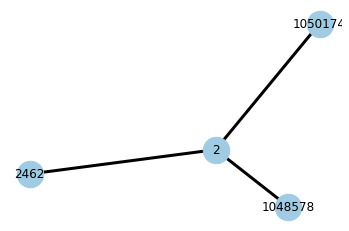

In [28]:
# Organize the input and output of the programm
while True:
    print("Choose the node v = ")
    v = int(input())
    print("Set the treshold in metrs = ")
    treshold = float(input())
    if v in list(d.keys()):
        print("Compiling the neighbour graph ")
        neigh = neighbours(d,treshold,v,which_dist = 1)
        if len(neigh) == 0:
            print("There is not any neighbours with this treshold")
        else:  
            draw_neighbours(neigh,v)
        break
    else: 
        print("There is not node number ", v)

In [42]:
neibourhood = [v] + [i for i,_ in neigh]
draw_map(df,neibourhood,neibourhood,type_of_visualization = 1)

## Functionality 1 - Find the Neighborhood! (because the task was confusing)
It takes in input:

1) A node v

2) One of the following distances function: t(x,y), d(x,y) or network distance (i.e. consider all edges to have weight equal to 1).

3) A distance threshold d

In [30]:
# find the nodes which are < d from the source node
def neighborhood(G,source,treshold,type_dist):
    v1 = source
    cost = 0
    toDoSet = [v1]
    costSet = {v1 : 0}
    doneSet = []
    
    while (len(toDoSet) != 0 ):
        v = toDoSet[-1] # take the last element
        # remove node from toDoset and append node to the doneSet 
        toDoSet.remove(v) 
        doneSet.append(v) 
        for node in [node for node in G[v]]: # go through the neighbours of the node
            costSet[node[0]] = costSet[v] + node[type_dist] # check if the dist is okey
            if node[0] not in toDoSet and node[0] not in doneSet and costSet[node[0]] < treshold:
                toDoSet = [node[0]] + toDoSet # add new elements at the begining because we always take the elements from the tail
        
    return doneSet 

def draw_neighborhood(G,a):
    g = G.subgraph(a)
    pos = nx.spring_layout(g)
    colors = range(len(a) + 1)
    nx.draw_networkx_nodes(g, pos, node_size=700,node_color='#A0CBE2')
    nx.draw_networkx_edges(g, pos, edgelist = g.edges(),
                               width=3)
    nx.draw_networkx_labels(g, pos)
    plt.show()
#a = neighborhood(d,1,2000,2)   
#draw_neighborhood(G,a)

Choose the node v = 
2
Choose the type of distance: 1 - km, 2 - time, 3 - network dist
3
Set the treshold = 
10
Compiling the neighbour graph 


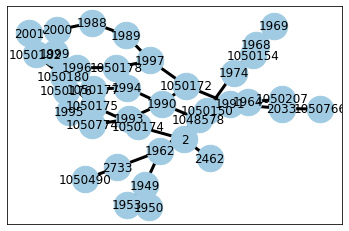

In [32]:
# Organize the input and output of the programm
while True:
    print("Choose the node v = ")
    v = int(input())
    print("Choose the type of distance: 1 - km, 2 - time, 3 - network dist")
    type_dist  = int(input())
    print("Set the treshold = ")
    treshold = float(input())
    if v in list(d.keys()):
        print("Compiling the neighbour graph ")
        a = neighborhood(d,v,treshold,type_dist)   
        if len(a) == 0:
            print("There is not any neighbours with this treshold")
        else:  
            draw_neighborhood(G,a)
        break
    else: 
        print("There is not node number ", v)

In [43]:
neibourhood = a
draw_map(df,neibourhood,neibourhood,type_of_visualization = 1)

## Functionality 3 - Shortest Ordered Route
It takes in input:

1) A node H

2) A sequence of nodes p = [p_1, ..., p_n]

3) The following distances function: network distance (all edges to have weight equal to 1).

Task: Implement an algorithm that returns the shortest walk that goes from H to p_n, and that visits in order the nodes in p.

In [44]:
# Check if the nodes are connected
# the idia with toDoSet and doneSet 
def connected(G,source,dest):
    v1,v2 = source,dest
    toDoSet = [v1]
    doneSet = [v2]
    while (len(toDoSet) != 0 ):
        v = toDoSet[-1]
        toDoSet.remove(v)
        doneSet.append(v)
        for node in [node_ for node_,_,_,_ in G[v]]: # take the list of nodes ( neigh ) from [(node1,_,_,_),...] to [node1,...]
            if node == v2:
                return doneSet
            if node not in toDoSet and node not in doneSet:
                toDoSet = [node] + toDoSet
    return [] 
a = connected(d,source = 1,dest = 87)            

In [45]:
# extract the path from dijkstra algo
def find_path(all_search, source, dest):
    path = [dest]
    v = all_search[dest]
    path.append(v)
    while v != source:
        v = all_search[v]  
        path.append(v)
    return list(reversed(path))

def dijkstra(G, source, dest, type_dist = 3):
    frontier = q.PriorityQueue() # need to use this structure because key = number of vertex priority = cost 
    frontier.put(source, 0) # as we always start from  vertex with the cost smallest it is very usefull 
    came_from = {}
    cost_so_far = {}
    came_from[source] = None # initial point
    cost_so_far[source] = 0 # cost for initial point
    
    while not frontier.empty():
        current = frontier.get() # take the smallest one
        
        if current == dest:
            break
        
        for neigh in G[current]: # look throw neigh
            new_cost = cost_so_far[current] + neigh[type_dist] # change the cost
            if neigh[0] not in cost_so_far or new_cost < cost_so_far[neigh[0]]:
                cost_so_far[neigh[0]] = new_cost
                priority = new_cost
                frontier.put(neigh[0], priority)
                came_from[neigh[0]] = current # dict of parent-neigh 
    
    return find_path(came_from, source, dest), cost_so_far[dest]
# Find the shortest path (with ordered nodes)
def sh_or_route(H, p, G, type_dist = 3):
    all_path = []
    all_cost = 0
    set_nodes = [H] + p
    if all([len(connected(G, set_nodes[i], set_nodes[i+1])) > 0 for i in range(len(set_nodes) - 1)]): # if nodes are connected
        for i in range(len(set_nodes) - 1):
            path, cost = dijkstra(G, set_nodes[i], set_nodes[i+1])
            all_cost += cost
            all_path.extend(path)
    else:
        print("Not possible")
    return all_path, all_cost
# this function draw the path (blue node is source, pint nodes is the set and red node is the destination)
def draw_path(g,path,p):
    color_map = []
    u_path = list(set(path))
    for i in range(len(u_path)):
        if i == 0:
            color_map.append('blue')
        elif i == len(u_path) - 1:
            color_map.append('red') 
        elif u_path[i] in p[:-1]:
            color_map.append('pink')  
        else: color_map.append('green')      
    nx.draw(g,node_color = color_map, )
    plt.title('Blue - source, pink - set of nodes, red - destination')

    plt.show()

Input the source node:
2
Input the sequence of nodes, (for ex: '1 2 3 4 5 6 7')
1 3 4 5 6 7


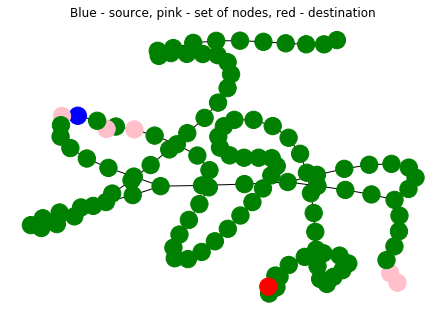

In [46]:
print("Input the source node:")
H = int(input())
print("Input the sequence of nodes, (for ex: '1 2 3 4 5 6 7')")
p = list(map(int,input().split()))

if all([len(d[i]) > 0 for i in [H] + p]):
    path,cost = sh_or_route(H,p,d,type_dist = 3)    
    g = G.subgraph(path)
    draw_path(g,path,p) 
else:
    print("Not possible, one of the nodes not in the graph")

In [97]:
set_nodes = [H] + p
draw_map(df,set_nodes,path,type_of_visualization = 3)

Which Functionality do you want to use?
3
Input the source node:
2
Input the sequence of nodes, (for ex: '1 2 3 4 5 6 7')
1 4 3 5 6 7


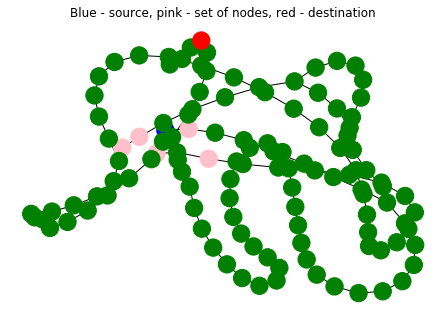

In [96]:
print("Which Functionality do you want to use?")
while True:
    func = int(input())
    if func in [0,1,2,3,4]:
        break
    else:
        print("There is not your functionalyty, choose between 0 - 4")
if func == 0:
    # Organize the input and output of the programm
    while True:
        print("Choose the node v = ")
        v = int(input())
        print("Set the treshold = ")
        treshold = float(input())
        if v in list(d.keys()):
            print("Compiling the neighbour graph ")
            neigh = neighbours(d,treshold,v,which_dist = 1)
            if len(neigh) == 0:
                print("There is not any neighbours with this treshold")
            else:  
                draw_neighbours(neigh,v)
                neibourhood = [v] + [i for i,_ in neigh]
                draw_map(df,neibourhood,neibourhood,type_of_visualization = 1).save("my_map0.html")
                print("Check the route into the your current filder")
            break
        else: 
            print("There is not node with the number ", v)
elif func ==1:
    # Organize the input and output of the programm
    while True:
        print("Choose the node v = ")
        v = int(input())
        print("Choose the type of distance: 1 - km, 2 - time, 3 - network dist")
        type_dist  = int(input())
        print("Set the treshold = ")
        treshold = float(input())
        if v in list(d.keys()):
            print("Compiling the neighbour graph ")
            a = neighborhood(d,v,treshold,type_dist)   
            if len(a) == 0:
                print("There is not any neighbours with this treshold")
            else:  
                draw_neighborhood(G,a)
                neibourhood = a
                draw_map(df,neibourhood,neibourhood,type_of_visualization = 1).save("my_map1.html")
                print("Check the route into the your current filder")
            break
        else: 
            print("There is not node number ", v)
elif func == 2:
    pass
elif func == 3:
    print("Input the source node:")
    H = int(input())
    print("Input the sequence of nodes, (for ex: '1 2 3 4 5 6 7')")
    p = list(map(int,input().split()))

    if all([len(d[i]) > 0 for i in [H] + p]):
        path,cost = sh_or_route(H,p,d,type_dist = 3)    
        g = G.subgraph(path)
        draw_path(g,path,p) 
        set_nodes = [H] + p
        draw_map(df,set_nodes,path,type_of_visualization = 3).save("my_map3.html")
        print("Check the route into the your current filder")
    else:
        print("Not possible, one of the nodes not in the graph")
elif func == 4:
    pass
    

In [32]:
import json
import collections
import pandas as pd 
import numpy as np
from io import StringIO 
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import heapq
from shapely.geometry import Point, Polygon
import json, string
import requests
import geocoder
from folium import Map, Marker, GeoJson, LayerControl
from ediblepickle import checkpoint
from tqdm import tqdm_notebook
import os 
import folium
from folium import plugins
from collections import defaultdict


In [35]:
coordinates=Node_data
distance=Distance_data
traveltime=Travel_time_data

distance.rename({'Id_Node1': 'Node1', 'Id_Node2': 'Node2', 'd(Id_Node1,Id_Node2)':'Distance'}, axis=1,inplace=True)
traveltime.rename({'t(Id_Node1, Id_Node2)': 'TimeTravel'}, axis=1,inplace=True)

coordinates['Latitude']=coordinates['Latitude']/10**6
coordinates['Longitude']=coordinates['Longitude']/10**6

In [37]:
def spanning_tree_distance():
    print('Choose from which node start')
    node=int(input())
    mst = defaultdict(set)
    visited = set([node])
    edges = [(dist,node,to) for to,dist,_,_ in d[node]]
    heapq.heapify(edges)

    while edges:
        dist, frm, to = heapq.heappop(edges) #Pop and return the smallest item from the heap, maintaining the heap invariant.
        if to not in visited:
            visited.add(to)
            mst[frm].add(to)
            for to_next, dist,_,_ in d[to]:
                if to_next not in visited:
                    heapq.heappush(edges, (dist, to, to_next)) #Push the value item into the heap, maintaining the heap invariant.
    return mst


In [38]:
def spanning_tree_time():
    print('Choose from which node start')
    node =int(input())   
    mst = defaultdict(set)
    visited = set([node])
    edges = [(time,node,to) for to,_,time,_ in d[node]]
    heapq.heapify(edges)

    while edges:
        time, frm, to = heapq.heappop(edges) #Pop and return the smallest item from the heap, maintaining the heap invariant.
        if to not in visited:
            visited.add(to)
            mst[frm].add(to)
            for to_next,_,time,_ in d[to]:
                if to_next not in visited:
                    heapq.heappush(edges, (time, to, to_next)) #Push the value item into the heap, maintaining the heap invariant.
    return mst



In [39]:
def spanning_tree_weight():
    print('Choose from which node start')
    node=int(input())
    mst = defaultdict(set)
    visited = set([node])
    edges = [(weight,node,to) for to,_,_,weight in d[node]]
    heapq.heapify(edges)

    while edges:
        weight, frm, to = heapq.heappop(edges) # Pop and return the smallest item from the heap, maintaining the heap invariant.
        if to not in visited:
            visited.add(to)
            mst[frm].add(to)
            for to_next,_,time,_ in d[to]:
                if to_next not in visited:
                    heapq.heappush(edges, (weight, to, to_next)) #Push the value item into the heap, maintaining the heap invariant.
    return mst


In [40]:
from collections import defaultdict
nodini=[]
print('Choose how many nodes consider for the spanning tree')
n=int(input())
print('Choose which nodes consider')
for i in range(0,n):
    nodini.append(int(input()))
print('Choose which method use for find the smartest Network:Time, Weight, Distance. p.s. If you are not interest just write "quit"') 

a=input().lower()
if a=='time':
    b=dict(spanning_tree_time())
elif a=='weight':
    b=dict(spanning_tree_weight())

elif a=='distance':
    b=dict(spanning_tree_distance())
elif a=='quit':
    print(':(')

else:
    print('What did you say? please repeat!')





Choose how many nodes consider for the spanning tree
4
Choose which nodes consider
1
1048577
2
1048588
Choose which method use for find the smartest Network:Time, Weight, Distance. p.s. If you are not interest just write "quit"
Time
Choose from which node start
2


In [41]:
#frontend

Values=[]
for i in range(len(nodini)):

    try:
        Values.append(b[nodini[i]])
    except:
          continue

result_spanning = pd.DataFrame(list(b.items()), columns=['Id_Node', 'Connection'])

lista = []
for i in range(len(Values)):
    lista.append(result_spanning[result_spanning['Connection']==Values[i]])

result_spanning_1 = pd.concat(lista)

df_final = pd.merge(result_spanning_1, coordinates, on = 'Id_Node', how = 'inner')
df_final_1 = pd.merge(result_spanning, coordinates, on = 'Id_Node', how = 'inner')


In [42]:
def visualization_spanning_tree():    
#built the map centralized on the median of the coordinates  
    map = folium.Map(location=[np.median((df_final['Longitude']).tolist()),
                               np.median((df_final['Latitude']).tolist())], default_zoom_start=15)
    
#add marker, set of nodes result of spanning tree algorithm
    for i in tqdm_notebook(range(0,len(df_final))):
        folium.CircleMarker(location = [((df_final['Longitude']).values)[i], 
                                                         ((df_final['Latitude']).values)[i]],
                                                 number_of_sides = 4,
                                                 radius = 10,
                                                 weight = 8,
                                                 color ='red',
                                                 fill_opacity = 0.8).add_to(map)
    for i in tqdm_notebook(range(0,len(df_final))):
        folium.Marker(location = [((df_final['Longitude']).values)[i], 
                                                         ((df_final['Latitude']).values)[i]],
                                                 number_of_sides = 4,
                                                 radius = 10,
                                                 weight = 8,
                                                 fill_opacity = 0.8).add_to(map)

#adding connection between two node
    for i in tqdm_notebook(range(0,len(df_final)-1)):
        folium.PolyLine(locations = [(((df_final['Longitude']).values)[i], 
                                      ((df_final['Latitude']).values)[i]), 
                                     (((df_final['Longitude']).values)[i+1], 
                                      ((df_final['Latitude']).values)[i+1])], 
                        line_opacity = 0.5,color='red').add_to(map)
    folium.CircleMarker([((df_final['Longitude']).values)[i],((df_final['Latitude']/1000000).values)[i]],
                        radius=15, color='red').add_to(map)
#weight represent the dimension of the node
#radius the shape
#opacity 
    map.save("Spanning_tree.html")

    return map

In [43]:
visualization_spanning_tree()

'reference'
https://deparkes.co.uk/2019/02/27/folium-lines-and-markers/

# Question 4 + Visualization

In [4]:
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
import itertools


## Loading datasets, creating a pandas dataframe for each file.

In [5]:
import pandas as pd
import networkx as nx
import itertools


tdist = pd.read_csv(r"CALtd.csv")
rdist = pd.read_csv(r"CALrd.csv")
nodexy = pd.read_csv(r"CALnodes.csv")

G1=nx.Graph()
G1.add_nodes_from(nodexy['id'])
edges1=rdist[['node1','node2']].values.tolist()
G1.add_edges_from(edges1)

G2=nx.Graph()
G2.add_nodes_from(nodexy['id'])
edges2=tdist[['node1','node2']].values.tolist()
G2.add_edges_from(edges2)

Gr = nx.dense_gnm_random_graph(20, 40, seed=None)

## Solution 1 Explained

The solution to this problem is at least NP-hard. Why? A similar problem studied in literature is the Hamiltonian path problem. This problem attempts to determine whether a Hamiltonian path (a path in an undirected or directed graph that visits each vertex exactly once). This problem is a NP-Complete problem. We attempt to solve this problem with a function MinRoute.
The first element of the function is the id of the starting node, then this is followed by the id's of the nodes that have to be visited, lastly one has to specify either distype = 1 or distype = 0 even though if the weights of the edges are to be assumed to be equal to one it won't matter whether the distance is time or length. The shortest distance will be the list with the shortest length.

Step 1: Making the networkx graph with nodes and egdes. Establishing whether the path is possible given the initial and final points using nx.has_path. If path is impossible, print "not possible".

Step 2 : Only 1 Node -

In the case there is only one starting node and one other node to be visited, the solution will simply be the shortest path between these 2 points, and in this case networkx module simply needs to call shortest_path and using dijkstra's algorithm the ouput will be a list representing the shortest path.

Step 3: Multiple intermediate nodes -

In the more complex case where there are multiple intermediate nodes to be visited the solution attempted is considerably harder and more inefficient.

i) The program first tries to rely on pure luck by using the shortest path algorithm with source = H and target = p_n. Once this shortest path is computed and stored as "slucky" then it checks if all the elements of p are in "slucky". If this is the case (very unlikely) then the solution is found.
    
ii)  In the case the input isn't "lucky" then the program goes on calculating all the paths connecting initial and final point. It creates a dataframe with a column for each of these paths. Then it checks if the intermediate nodes are all in present in these paths, then it returns the path with minimum length

Advantage: This method is precise and returns correct paths
Problem: With such a large dataset the function is computationally inefficient, so inefficient that it becomes unfeasible. Therefore we attempt a different solution later on.

    


## Solution 1 (small networks/brute force)

In [6]:
def MinRoute(H,*p,distype):
    nodelist = []
    paths = []
    
    for i in p:
        nodelist.append(i)
    
    if distype == 1:
        G= G1
        
    elif distype == 2:
        G = G2
        
    elif distype ==3:
        G = Gr
        
    if nx.has_path(G,H,nodelist[-1]) == False:
            print("No possible path")
            
    if len(nodelist) == 1:
            return nx.shortest_path(G,source= H, target =nodelist[0])
    elif len(nodelist) > 1:
        slucky = nx.shortest_path(G, source = H, target = nodelist[-1])
        if set(p) <= set(slucky):
            shortpaths = slucky
                         
        else:
            for path in nx.all_simple_paths(G,source = H, target = nodelist[-1]):
                if set(nodelist) <= set(path):
                    line = ','.join([str(p) for p in path])
                    paths.append(line)
            for i in range(len( paths )):
                paths[int(i)] = list(map(int, paths[int(i)].split(","))) 
            shortpaths = []
            a = min(paths, key=len)
            for el in range(len(paths)):
                if len(paths[el]) == len(a):
                    shortpaths.append(paths[el])
    
    return shortpaths


def drawShortPath(H,*sp, distypes):
    shortp = []
    for i in sp:
        shortp.append(i)
    k = list(MinRoute(H,*shortp,distype=distypes))
    
    a = list(k[0])
    if distypes == 3:    
        gs = Gr
    elif distypes == 1:
        gs = G1
    elif distypes == 2:
        gs == G2
    pos = nx.spring_layout(gs)
    
    
    
    color_map = []
    u_path = list(set(a))
    for i in range(len(u_path)):
        if i == 0:
            color_map.append('blue')
        elif i == len(u_path) - 1:
            color_map.append('red') 
        else: color_map.append('green')  
    nx.draw_networkx_nodes(gs, pos,nodelist = a, node_size=700,node_color=color_map)
    nx.draw_networkx_edges(gs,pos, nodelist = a, edgelist = gs.edges(),width=3)
    nx.draw_networkx_labels(gs, pos)
    plt.title('Shortest walk going through all nodes')
    plt.show()

    


//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:518: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


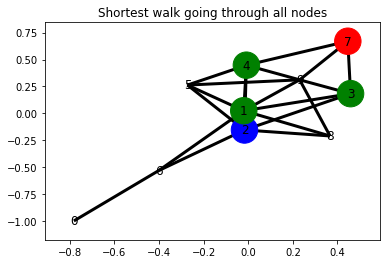

Shortest path going through all nodes [2, 3, 1, 4, 7]


In [7]:
Gr = nx.dense_gnm_random_graph(10, 20, seed=None)

k = list(MinRoute(2,3,4,7,distype=3))
drawShortPath(2,3,4,7,distypes=3)
print ("Shortest path going through all nodes" ,k[0])


## Output

Function "MinRoute" returns a list of lists with numbers representing the nodes of the shortest path possible between a set of points. Function "drawMR" then plots one of the shortest paths (they are all equivalent in length) and shows the starting node in blue, the ending node in red and all the in between nodes in green. Only the nodes that are traversed are labeled.

This function is not feasible with large n and e (number of nodes and egdes) but to prove its accuracy we create a small graph with random nodes and edges stored as Gr and execute the algorithms. By choosing distype = 3 both algorithms work on this small network (Gr).




# Solution 2 (Large Networks, Small p, Heuristical)

This Solution we came up with relies on dijkstra's algorithm for the shortest path and the intuition that if we were to cross all the points in some order, this order would depend on the shortest possible path passing between all these points. Since this order is at least NP-hard to find and would be computationally complex for any machine we use a proxy for this order.
The proxy: A permutation of the points to be traversed (excluding first and last points H and P_N). If there are 3 mid points there will be 3! possible permutations of the order. For each possible state of the order we calculate the path length using dijkstra. The order with minumum path length is chosen. Then the first and last points are added to the list since their state in the order is fixed. Finally dijkstra is used to return the paths between the first and second point in the order, then second and third and so on until the last point. These paths are added together to get an approximate but possibly correct shortest path covering all points.

Why approximate? The approximation comes from the fact that some paths might be redundant given they pass through the same point twice or more times when there could have been a shorter total path. Say ShortCover finds the shortest path from A to B
is A,D,E,C,B. This is because D E C is the shortest path in the permutations of E,D and C, so its faster than C-E-D or any other combination. But what if there is a path A,X,B that still manages to pass through D E and C but is shorter than what ShortCover has found? This is a possibility therfore this algorithm is not 100% precise.


Small P: The downfall of this algorithm is that it becomes increasingly more inefficient as the number of intermediate points increases. For p intermediate points the algorithm repeats dijstra p! times. This algorithm can handle large number od edges and nodes but not very large number of intermediate points to be crossed.



In [8]:
def ShortestCover(H,*p,distype):
#Made a list with all points (initial, mid and last)
    pts = []
    for i in p:
        pts.append(i)
    pts.insert(0,H)
    
#Given the distype, the graph made depends on either real distance or time distance.
    for i in p:
        pts.append(i)
    
    if distype == 1:
        G= G1
        
    elif distype == 2:
        G = G2
        
    elif distype ==3:
        G = Gr
    
    if nx.has_path(G,H,pts[-1]) == False:
            print("No possible path")
#Permutating the possible paths

    midpts = pts[1:-1]
    perm = list(itertools.permutations(midpts))
    
    out = [0] * (len(perm))
    
#Finding out path with shortest length

    for i in range(len(perm)):
        for j in range(len(perm[0])-1):
            out[i] += (nx.dijkstra_path_length(G,source = perm[i][j],target =perm[i][j+1])) 

    bpath = out.index(min(out))
    bmidi = list(perm[bpath])
    finalpath = [0]* len(pts)
    finalpath[0] = pts[0]
    finalpath[-1] = pts [-1]
    
    for i in range(1,len(pts)-1):
        finalpath[i] = bmidi [i-1]
        
#Given the order of points to be traversed calculated in the step above, find shortest paths between points, then add all paths together.
    allpath = []   
    for i in range(len(finalpath)-1):
        allpath.append(nx.dijkstra_path(G, source=finalpath[i], target = finalpath[i+1], weight='weight'))
    for lp in range(1,len(allpath)):
        allpath[lp].pop(0)
        
        
    allpath = list(itertools.chain(*allpath))
    
    return allpath


In [9]:
alpha = ShortestCover(123,31,28,1048601,64,distype =1)
print(alpha)

[123, 126, 1048676, 106, 105, 1048660, 1048653, 1048634, 1048633, 1048635, 1048632, 69, 46, 47, 1048614, 2472, 1048617, 51, 1050719, 52, 1048598, 28, 1050699, 1050700, 1048601, 31, 1050698, 1048627, 64]


# Large Scale Visualization.

Function draw SC takes as input the output of the ShortestCover function, which is simply a list of integers.

In [14]:
def drawSC(scpath):
    a = scpath
    
    mdf = rdist.loc[rdist['node1'].isin(a), ['color']] = 'yellow'
      
    g = nx.Graph()

    for i, elrow in rdist.iterrows():    
        g.add_edge(elrow[0], elrow[1], **elrow[2:].to_dict())

    for i, nlrow in nodexy.iterrows():
        nx.set_node_attributes(g, {nlrow['id']:  nlrow[1:].to_dict()})   

    node_positions = {node[0]: (node[1]['X'], -node[1]['Y']) for node in g.nodes(data=True)}
    edge_colors = [e[2]['color'] for e in list(g.edges(data=True))]


    nx.draw(g, pos=node_positions, edge_color=edge_colors, node_size=0.05, node_color='black', width = 2)
    plt.figure(figsize=(100, 60))
    plt.title('Shortest walk going through all nodes')
    plt.show()

    
  



In [ ]:
drawSC(alpha)